In [26]:
import shutil
import sys
import os
import json
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ultralytics import YOLO
import ultralytics
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import matplotlib.ticker as ticker
import warnings
import random
import seaborn as snsz
import csv
import datetime

In [27]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
from tensorflow.keras.layers import *


import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
def create_num_to_label():
    with open("IP102/ip102_v1.1/num_label_reduced.txt") as f:
        num_to_label = {}
        for text in f.read().split("\n"):
            n,l = text.split(' ',1);
            num_to_label[n] = l.strip()

    return num_to_label

num_to_label = create_num_to_label()

def create_name_to_num():
    with open("IP102/ip102_v1.1/name_num_table.txt") as f:
        name_to_num = [] # class data
        for l in f.read().split("\n"):
            v = tuple(l.split())
            if v:
                if str(int(v[1])+1) in num_to_label.keys():
                    v = [v[0],str(int(v[1])+1)] # to fit the format in num_to_label.txt
                    name_to_num.append(v)
    
    return np.array(name_to_num)

name_to_num = create_name_to_num()

In [29]:
original_DA_num_to_label = {23:"corn borer", 52:"blister beetle"} # original num_to_label

DA_label_to_num = {"corn borer":0, "blister beetle":1} # num_to_label for CGAN

def assign_augment_img(name_to_num):
    DA_path_to_num = []
    src_directory = "IP102/ip102_v1.1/images/"
    for name, num in zip(name_to_num[:, 0], name_to_num[:, 1]):
        num = int(num)
        if num in np.array(list(original_DA_num_to_label.keys())):
            DA_path_to_num.append([src_directory + name, DA_label_to_num[original_DA_num_to_label[num]]])

    return np.array(DA_path_to_num)


DA_path_to_num = assign_augment_img(name_to_num)
print(len(DA_path_to_num))

3595


In [61]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

train_size = 1500*2
batch_size = 64
img_size = 128
epoch_count = 300
noise_dim = 100 
n_class = 2
l_rate_g = 0.0001
l_rate_d = 0.0004
l_rate_c = 0.0004
b1 = 0.5
b2 = 0.999
r = 0.2
weight_decay = 1e-4
l2_reg = tf.keras.regularizers.l2(1e-4)



tags = list(DA_label_to_num.keys())

# Sample data
image_paths = DA_path_to_num[:,0][:train_size]
labels = DA_path_to_num[:,1][:train_size]

# Load images and labels
X_train = []
y_train = []

for path, label in zip(image_paths, labels):
    img = load_img(path, target_size=(img_size,img_size))
    img_array = img_to_array(img)
    X_train.append(img_array)
    y_train.append(label)

X_train = np.array(X_train).astype("float32") / 255.0

# Encode string labels into integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = np.array(y_train)

X_train = (X_train - 127.5) / 127.5
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

def data_generator():
    for x, y in zip(X_train, y_train):
        yield x, y

dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=X_train.shape[1:], dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)  # adjust if y is not scalar
    )
)

dataset = dataset.shuffle(buffer_size=1000).batch(batch_size, drop_remainder=True)

In [62]:
print(dataset)
print("-------images---------")
print(f"Data Amount: {len(X_train)}")
print(f"Image Size : {len(X_train[0])} x {len(X_train[0,0])}")
print(f"Channel    : {len(X_train[0,0,0])}")
print(f"Shape      : {X_train.shape}")

print("-------labels---------")
print(f"Data Amount: {len(y_train)}")
print(f"Shape      : {y_train.shape}")  

<_BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int32, name=None))>
-------images---------
Data Amount: 3000
Image Size : 128 x 128
Channel    : 3
Shape      : (3000, 128, 128, 3)
-------labels---------
Data Amount: 3000
Shape      : (3000,)


### GACN with tensorflow

In [89]:
bce_loss = tf.keras.losses.BinaryCrossentropy()
sparse_ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()

def discriminator_loss(pred_real_source, pred_fake_source, pred_real_class, pred_fake_class, true_labels):
    ls_real = bce_loss(tf.ones_like(pred_real_source), pred_real_source)
    ls_fake = bce_loss(tf.zeros_like(pred_fake_source), pred_fake_source)
    ls = ls_real + ls_fake

    lc_real = bce_loss(tf.cast(true_labels, tf.float32), pred_real_class)
    lc_fake = bce_loss(tf.cast(true_labels, tf.float32), pred_fake_class)
    lc = lc_real + lc_fake

    return ls + lc

def generator_loss(pred_fake_source, pred_fake_class, true_labels, classifier_pred_real):
    ls_f = bce_loss(tf.ones_like(pred_fake_source), pred_fake_source)
    lc_f = bce_loss(tf.cast(true_labels, tf.float32), pred_fake_class)
    ltcr = bce_loss(tf.cast(true_labels, tf.float32), classifier_pred_real)
    return ls_f + lc_f + ltcr

def classifier_loss(pred_fake_class, pred_real_class, true_labels):
    global r
    y = tf.cast(true_labels, tf.float32)
    loss_fake = bce_loss(y, pred_fake_class)
    loss_real = bce_loss(y, pred_real_class)
    return r * loss_fake + loss_real


d_optimizer=Adam(learning_rate=l_rate_d, beta_1 =b1, beta_2 = b2)
g_optimizer=Adam(learning_rate=l_rate_g, beta_1 =b1, beta_2 = b2)
c_optimizer=Adam(learning_rate=l_rate_c, beta_1 =b1, beta_2 = b2)

### generator

In [87]:
# LeakyReLU slope
alpha = 0.2

def build_generator():
    global alpha
    global noise_dim
    global n_class
    # Parameters
    RC = 512  # feature map depth after reshape

    z = Input(shape=(noise_dim,), name="noise_input")
    c = Input(shape=(n_class,), name="label_input")
    concatenate = Concatenate(name="concat_z_c")([z, c])  # shape: (noise_dim + n_class,)
    
    x = Dense(4 * 4 * RC, name="dense_map")(concatenate)
    x = LeakyReLU(alpha=alpha, name="dense_activation")(x)
    input_gen = Reshape((4, 4, RC), name="reshape_to_feature_map")(x)

    
    gen = UpSampling2D(size=(2, 2), interpolation="bilinear")(input_gen)
    gen = Conv2D(512, kernel_size=3, padding="same")(gen)
    gen = LeakyReLU(alpha)(gen)
    
    gen = UpSampling2D(size=(2, 2), interpolation="bilinear")(gen)
    gen = Conv2D(256, kernel_size=3, padding="same")(gen)
    gen = LeakyReLU(alpha)(gen)
    
    gen = UpSampling2D(size=(2, 2), interpolation="bilinear")(gen)
    gen = Conv2D(128, kernel_size=3, padding="same")(gen)
    gen = LeakyReLU(alpha)(gen)
    
    gen = UpSampling2D(size=(2, 2), interpolation="bilinear")(gen)
    gen = Conv2D(64, kernel_size=3, padding="same")(gen)
    gen = LeakyReLU(alpha)(gen)
    
    gen = UpSampling2D(size=(2, 2), interpolation="bilinear")(gen)
    gen = Conv2D(32, kernel_size=3, padding="same")(gen)
    gen = LeakyReLU(alpha)(gen)
    
    out = Conv2D(3, kernel_size=3, padding="same", activation="sigmoid")(gen)
    model = Model(inputs=[z, c], outputs=out, name="Generator")

    return model

g_model = build_generator()
g_model.summary()


/home/ikuta_toma/Desktop/test/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_z_c          │ (None, 102)       │          0 │ noise_input[0][0… │
│ (Concatenate)       │                   │            │ label_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_map (Dense)   │ (None, 8192)      │    843,776 │ concat_z_c[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_activation    │ (None, 8192)      │          0 │ dense_map[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_to_feature… │ (None, 4, 4, 512) │          0 │ dense_activation… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_25    │ (None, 8, 8, 512) │          0 │ reshape_to_featu… │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 8, 8, 512) │  2,359,808 │ up_sampling2d_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_45      │ (None, 8, 8, 512) │          0 │ conv2d_150[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_26    │ (None, 16, 16,    │          0 │ leaky_re_lu_45[0… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 16, 16,    │  1,179,904 │ up_sampling2d_26… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_46      │ (None, 16, 16,    │          0 │ conv2d_151[0][0]  │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_27    │ (None, 32, 32,    │          0 │ leaky_re_lu_46[0… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 32, 32,    │    295,040 │ up_sampling2d_27… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_47      │ (None, 32, 32,    │          0 │ conv2d_152[0][0]  │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_28    │ (None, 64, 64,    │          0 │ leaky_re_lu_47[0… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 64, 64,    │     73,792 │ up_sampling2d_28… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,771,651 (18.20 MB)

 Trainable params: 4,771,651 (18.20 MB)

 Non-trainable params: 0 (0.00 B)

### Discriminator

In [90]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, BatchNormalization, Flatten, Dense

def build_discriminator(input_shape=(128, 128, 3), alpha=0.2):
    global n_class
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = LeakyReLU(alpha)(x)
    x = Dropout(0.5)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha)(x)
    x = Dropout(0.5)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha)(x)
    x = Dropout(0.5)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha)(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)

    source_output = Dense(1, activation='sigmoid', name='source')(x) # fake or real
    class_output = Dense(1, activation='sigmoid', name='class')(x) # class label (0 or 1)

    model = tf.keras.Model(inputs=inputs, outputs=[source_output, class_output], name="Discriminator")
    return model

d_model = build_discriminator()
d_model.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_156 (Conv2D) │ (None, 64, 64,    │      3,136 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_50      │ (None, 64, 64,    │          0 │ conv2d_156[0][0]  │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64, 64,    │          0 │ leaky_re_lu_50[0… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_157 (Conv2D) │ (None, 32, 32,    │    131,200 │ dropout_20[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_157[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_51      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 32, 32,    │          0 │ leaky_re_lu_51[0… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_158 (Conv2D) │ (None, 16, 16,    │    524,544 │ dropout_21[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_158[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_52      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 16, 16,    │          0 │ leaky_re_lu_52[0… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_159 (Conv2D) │ (None, 8, 8, 512) │  2,097,664 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_159[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_53      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 8, 8, 512) │          0 │ leaky_re_lu_53[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 32768)     │          0 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,825,666 (10.78 MB)

 Trainable params: 2,823,874 (10.77 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Classifier ResNet18

In [91]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, filters, kernel_size=3, stride=1, downsample=False):
    global l2_reg
    shortcut = x

    x = Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False, kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False, kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)

    if downsample:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, use_bias=False, kernel_regularizer=l2_reg)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet18():
    global n_class
    global l2_reg
    inputs = tf.keras.Input(shape=(128, 128, 3))

    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False, kernel_regularizer=l2_reg)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv2_x
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    # Conv3_x
    x = conv_block(x, 128, stride=2, downsample=True)
    x = conv_block(x, 128)

    # Conv4_x
    x = conv_block(x, 256, stride=2, downsample=True)
    x = conv_block(x, 256)

    # Conv5_x
    x = conv_block(x, 512, stride=2, downsample=True)
    x = conv_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg)(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="ResNet18")
    return model


c_model = build_resnet18()
c_model.summary()

Model: "ResNet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_160 (Conv2D) │ (None, 64, 64,    │      9,408 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_160[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_85 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ re_lu_85[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_161 (Conv2D) │ (None, 32, 32,    │     36,864 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_161[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_86 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_162 (Conv2D) │ (None, 32, 32,    │     36,864 │ re_lu_86[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_162[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_87 (ReLU)     │ (None, 32, 32,    │          0 │ add_40[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_163 (Conv2D) │ (None, 32, 32,    │     36,864 │ re_lu_87[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_163[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_88 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_164 (Conv2D) │ (None, 32, 32,    │     36,864 │ re_lu_88[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_164[0][0]

 Total params: 11,186,625 (42.67 MB)

 Trainable params: 11,177,025 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [93]:
def show_samples(num_samples):
    global n_class
    global g_model
    fig, axes = plt.subplots(n_class,num_samples, figsize=(10,5)) 
    fig.tight_layout()

    for l in np.arange(n_class):
      random_latent_vectors = tf.random.normal(shape=(num_samples, noise_dim))
      one_hot_real_labels = tf.one_hot(np.full(num_samples, l), depth=n_class, dtype=tf.float32)
        
      gen_imgs = g_model({"noise_input": random_latent_vectors, "label_input": one_hot_real_labels}, training=True)
      for j in range(gen_imgs.shape[0]):
        img = image.array_to_img(gen_imgs[j], scale=True)
        axes[l,j].imshow(img)
        axes[l,j].yaxis.set_ticks([])
        axes[l,j].xaxis.set_ticks([])

        if j ==0:
          axes[l,j].set_ylabel(tags[l])
    plt.show()

def plot_loss(loss):
    print(loss)
    plt.figure(figsize=(10, 5))
    plt.plot(loss) 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training generator Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [94]:
@tf.function
def train_step(dataset):

    global g_model
    global d_model
    global c_model
    global r
    global n_class
    
    real_images, real_labels = dataset
    one_hot_real_labels = tf.one_hot(real_labels, depth=n_class, dtype=tf.float32)

    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))

    
    generated_images = g_model({"noise_input": random_latent_vectors, "label_input": one_hot_real_labels })

    
    with tf.GradientTape() as tape:
        pred_fake_s, pred_fake_c = d_model(generated_images, training=True)
        pred_real_s, pred_real_c = d_model(real_images, training=True)
        d_loss = discriminator_loss(pred_real_s, pred_fake_s, pred_real_c, pred_fake_c, real_labels)
    grads = tape.gradient(d_loss, d_model.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))

    
    with tf.GradientTape() as tape:
        fake_images = g_model({"noise_input": random_latent_vectors, "label_input": one_hot_real_labels}, training=True)
        pred_fake_s, pred_fake_c = d_model(fake_images, training=True)
        classifier_pred_real = c_model(real_images, training=False)

        g_loss = generator_loss(pred_fake_s, pred_fake_c, real_labels, classifier_pred_real)
    grads = tape.gradient(g_loss, g_model.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))


    with tf.GradientTape() as tape:
        pred_fake_cls = c_model(generated_images, training=True)
        pred_real_cls = c_model(real_images, training=True)
        c_loss = classifier_loss(pred_fake_cls, pred_real_cls, real_labels)

    grads = tape.gradient(c_loss, c_model.trainable_variables)
    c_optimizer.apply_gradients(zip(grads, c_model.trainable_variables))  

    return d_loss, g_loss, c_loss


In [95]:
def train(dataset, epochs=epoch_count):
    best_loss = float('inf')
    patience = 50
    wait = 0
    g_loss_list = []
    d_loss_list = []
    c_loss_list = []
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        start = time.time()
        itern = 0

        for image_batch in tqdm(dataset):
            d_loss, g_loss, c_loss = train_step(image_batch)
            itern=itern+1
        if (epoch+1) % 10 == 0:
            show_samples(3)
            g_model.save(f"{dic}/generator.keras")
            d_model.save(f"{dic}/discriminator.keras") 
            c_model.save(f"{dic}/classifier.keras")

        g_loss_list.append(g_loss.numpy())
        d_loss_list.append(d_loss.numpy())
        c_loss_list.append(c_loss.numpy())
        plot_loss(g_loss_list)
        with open(f"{dic}/loss.csv", 'a') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, itern, d_loss.numpy(), g_loss.numpy(), c_loss.numpy()])
            
            
        print (f'Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}, Classifier Loss: {np.mean(c_loss_list)}\n')
        print (f'Took {time.time()-start} seconds. \n\n') 

        # Early stopping check
        if np.mean(c_loss_list) < best_loss:
            best_loss = np.mean(c_loss_list)
            wait = 0
            print("New best classifier loss, resetting patience.")
        else:
            wait += 1
            print(f"No improvement. Patience: {wait}/{patience}")
        
        if wait >= patience:
            print("Early stopping triggered.")
            break

train_size       : 3000
batch_size       : 64
image_size       : 128
epoch            : 300
noise_dim        : 100
n_class          : 2
learning_rate_g  : 0.0001
learning_rate_d  : 0.0004
learning_rate_c  : 0.0004
beta_1           : 0.5
beta_2           : 0.999
fake_coefficient : 0.2
weight_decay     : 0.0001
---------------------------------
Epoch:  0


0it [00:00, ?it/s]E0000 00:00:1749990660.593909  995690 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDiscriminator_3/dropout_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
46it [00:31,  1.48it/s]

[8.591385]



/tmp/ipykernel_995690/3761388251.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


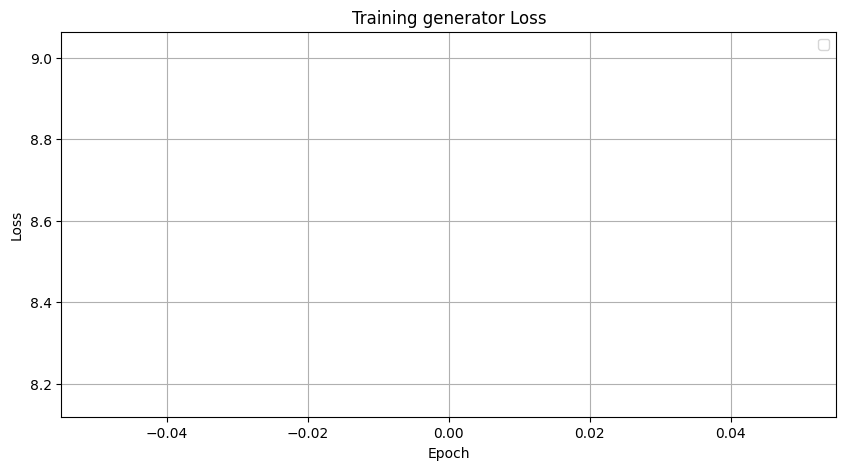

Epoch: 0 -- Generator Loss: 8.591384887695312, Discriminator Loss: 1.6147513389587402, Classifier Loss: 0.6663818955421448

Took 31.179558992385864 seconds. 


New best classifier loss, resetting patience.
Epoch:  1


46it [00:15,  3.02it/s]

[8.591385, 9.533569]


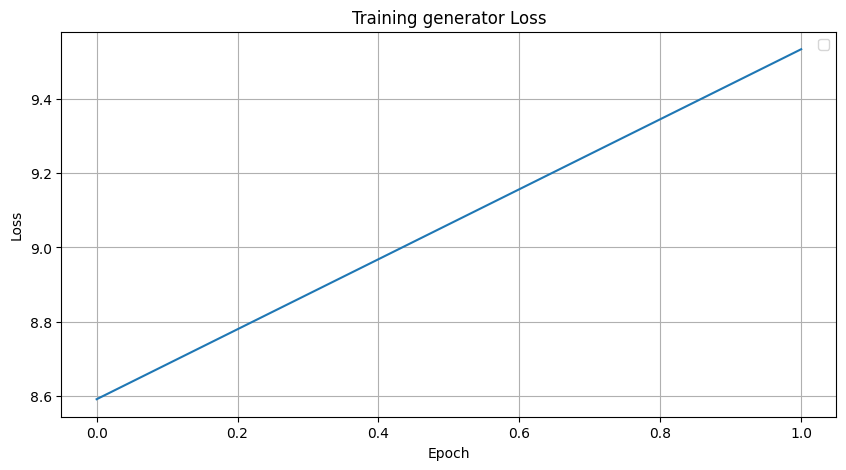

Epoch: 1 -- Generator Loss: 9.062477111816406, Discriminator Loss: 1.7862299680709839, Classifier Loss: 0.5751195549964905

Took 15.391005754470825 seconds. 


New best classifier loss, resetting patience.
Epoch:  2


46it [00:15,  2.99it/s]

[8.591385, 9.533569, 9.116479]


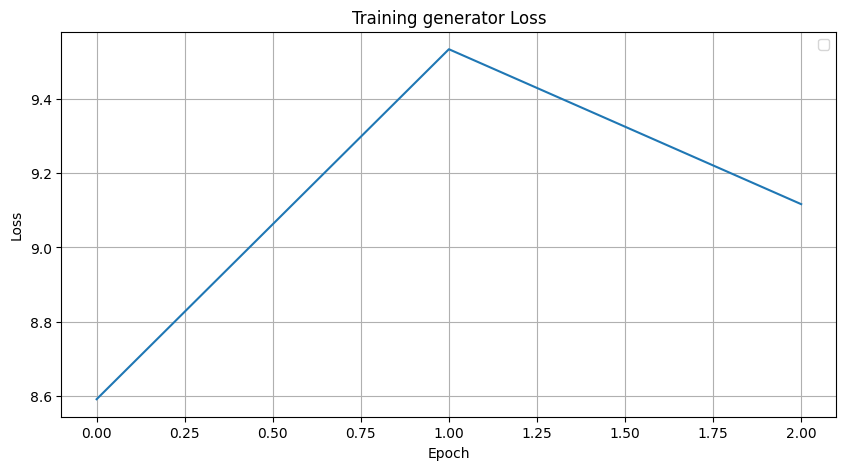

Epoch: 2 -- Generator Loss: 9.080477714538574, Discriminator Loss: 1.7126765251159668, Classifier Loss: 0.48261579871177673

Took 15.541733264923096 seconds. 


New best classifier loss, resetting patience.
Epoch:  3


46it [00:15,  2.98it/s]

[8.591385, 9.533569, 9.116479, 9.895554]


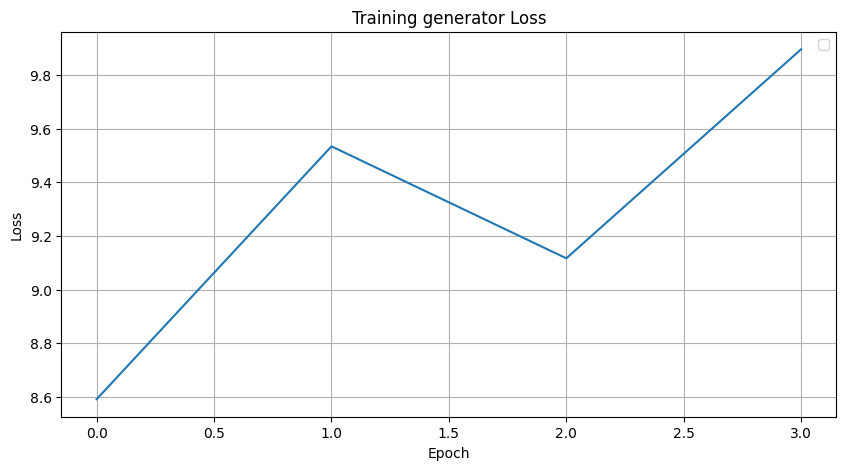

Epoch: 3 -- Generator Loss: 9.284246444702148, Discriminator Loss: 1.6016172170639038, Classifier Loss: 0.45859915018081665

Took 15.630577564239502 seconds. 


New best classifier loss, resetting patience.
Epoch:  4


46it [00:15,  2.97it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089]


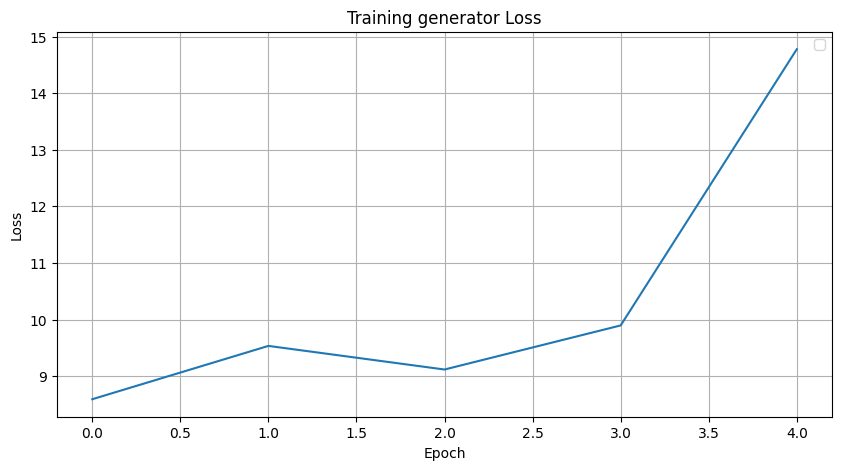

Epoch: 4 -- Generator Loss: 10.382814407348633, Discriminator Loss: 1.6017341613769531, Classifier Loss: 0.453227698802948

Took 15.686880111694336 seconds. 


New best classifier loss, resetting patience.
Epoch:  5


46it [00:15,  2.95it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846]


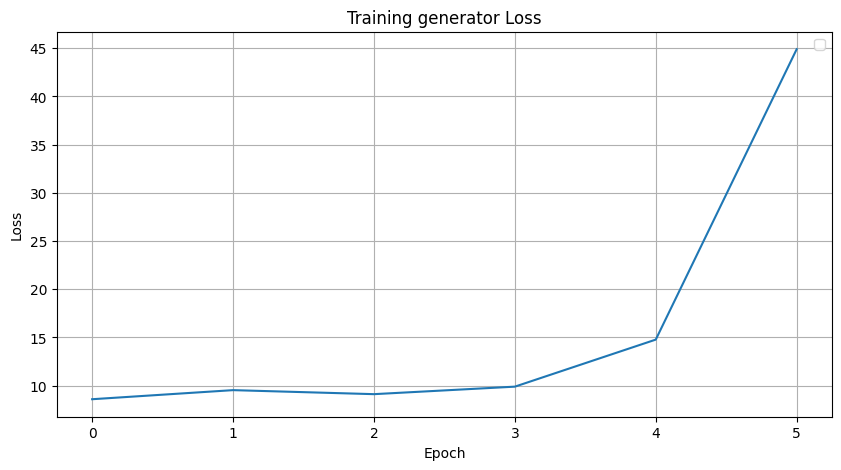

Epoch: 5 -- Generator Loss: 16.13648796081543, Discriminator Loss: 1.5432791709899902, Classifier Loss: 0.47170746326446533

Took 15.767017364501953 seconds. 


No improvement. Patience: 1/50
Epoch:  6


46it [00:15,  2.95it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145]


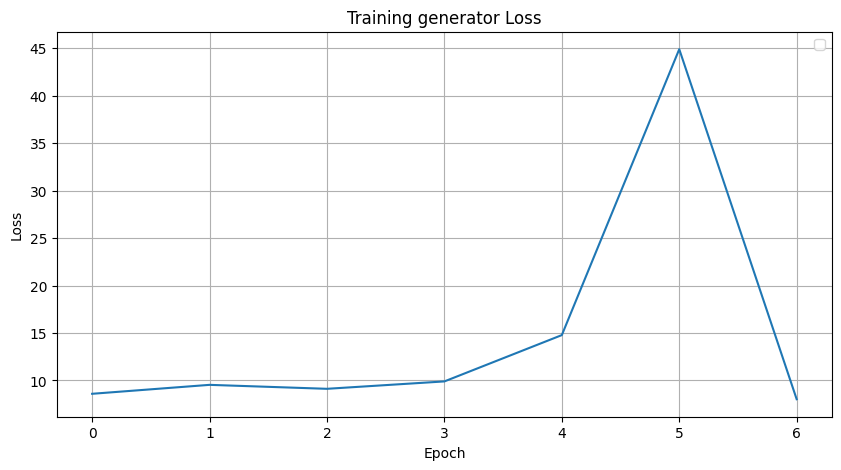

Epoch: 6 -- Generator Loss: 14.976866722106934, Discriminator Loss: 1.5234596729278564, Classifier Loss: 0.4570348262786865

Took 15.799481391906738 seconds. 


No improvement. Patience: 2/50
Epoch:  7


46it [00:15,  2.96it/s]


[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118]


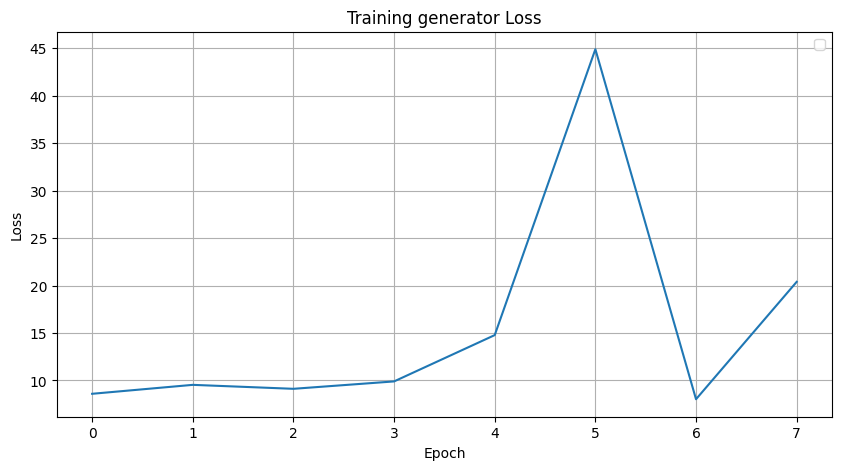

Epoch: 7 -- Generator Loss: 15.653397560119629, Discriminator Loss: 1.5409305095672607, Classifier Loss: 0.4568549394607544

Took 15.749390602111816 seconds. 


No improvement. Patience: 3/50
Epoch:  8


46it [00:15,  2.95it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539]


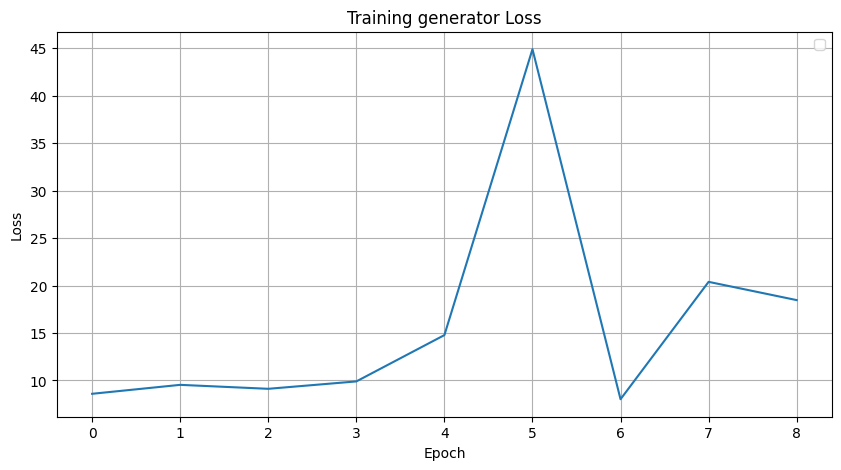

Epoch: 8 -- Generator Loss: 15.96574592590332, Discriminator Loss: 1.5060783624649048, Classifier Loss: 0.45246422290802

Took 15.795485019683838 seconds. 


New best classifier loss, resetting patience.
Epoch:  9


46it [00:15,  2.95it/s]


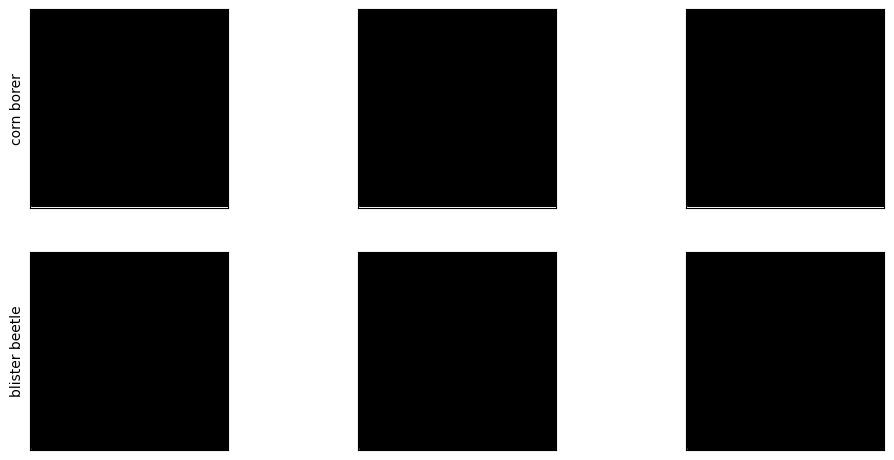

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415]


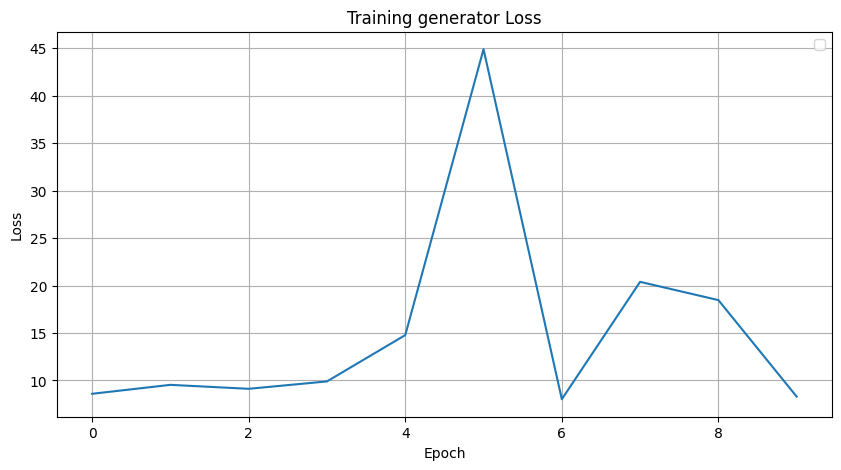

Epoch: 9 -- Generator Loss: 15.19842529296875, Discriminator Loss: 1.5046314001083374, Classifier Loss: 0.43904900550842285

Took 16.42321515083313 seconds. 


New best classifier loss, resetting patience.
Epoch:  10


46it [00:15,  2.98it/s]


[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009]


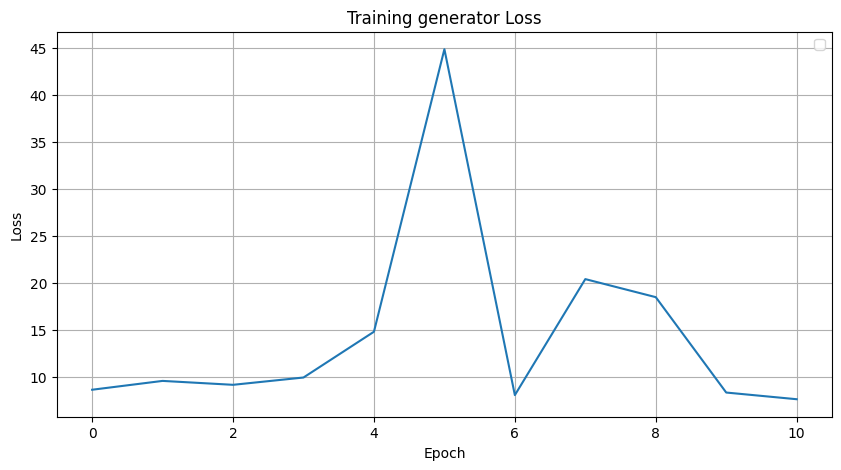

Epoch: 10 -- Generator Loss: 14.505849838256836, Discriminator Loss: 1.4617531299591064, Classifier Loss: 0.4328848123550415

Took 15.66941523551941 seconds. 


New best classifier loss, resetting patience.
Epoch:  11


46it [00:15,  2.97it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973]


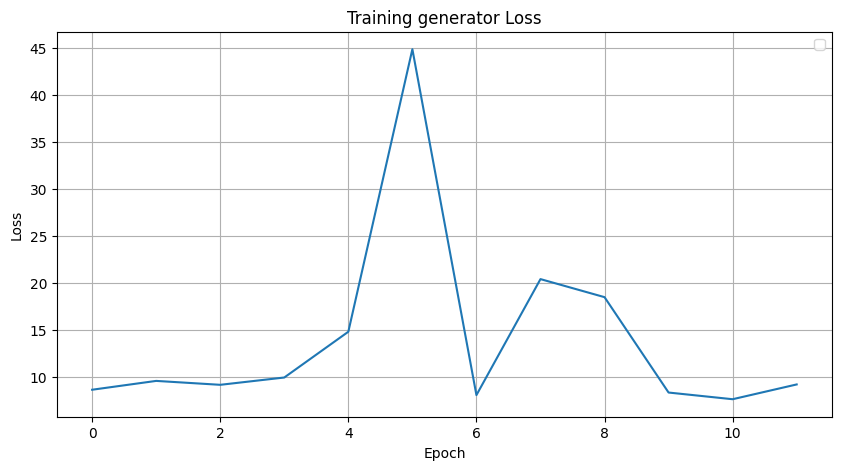

Epoch: 11 -- Generator Loss: 14.060027122497559, Discriminator Loss: 1.455911636352539, Classifier Loss: 0.4295172393321991

Took 15.661112785339355 seconds. 


New best classifier loss, resetting patience.
Epoch:  12


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462]


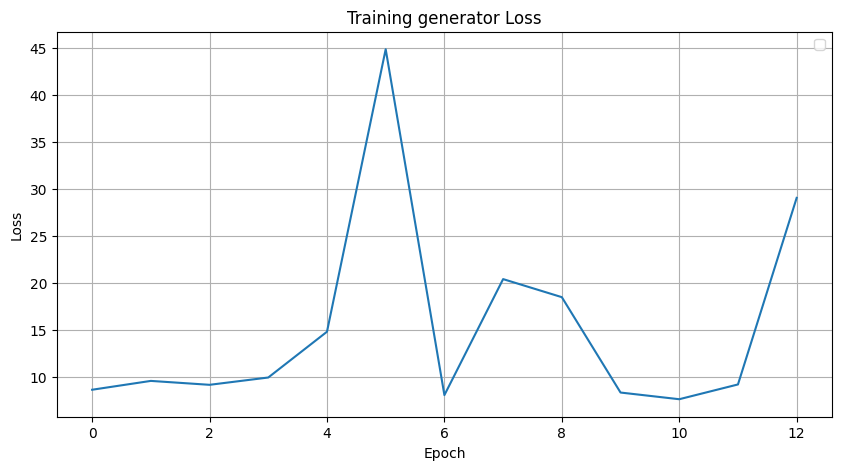

Epoch: 12 -- Generator Loss: 15.213521957397461, Discriminator Loss: 1.4575709104537964, Classifier Loss: 0.4153746962547302

Took 15.735264301300049 seconds. 


New best classifier loss, resetting patience.
Epoch:  13


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091]


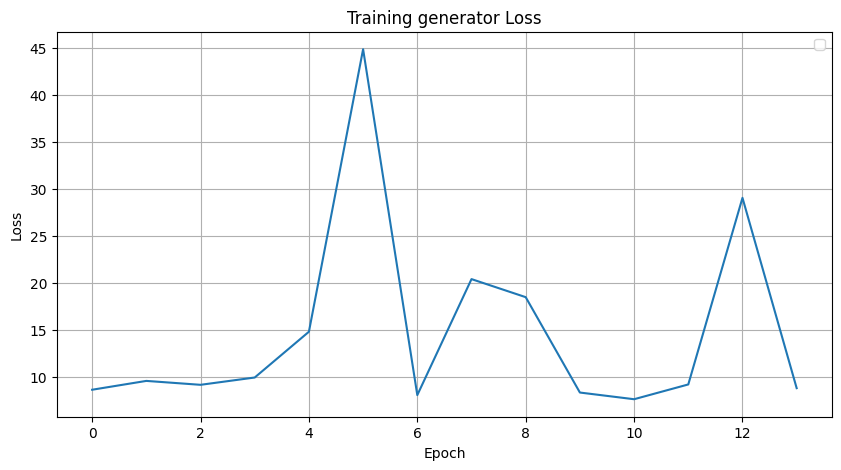

Epoch: 13 -- Generator Loss: 14.75249195098877, Discriminator Loss: 1.4590696096420288, Classifier Loss: 0.40177369117736816

Took 15.733400344848633 seconds. 


New best classifier loss, resetting patience.
Epoch:  14


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203]


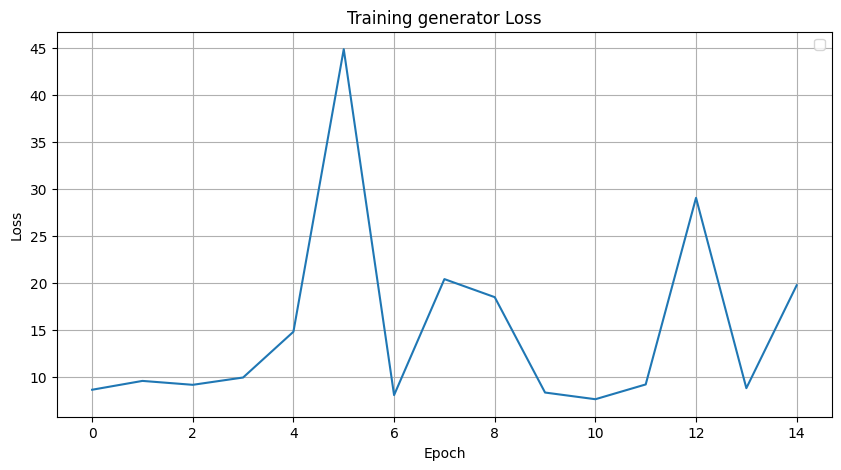

Epoch: 14 -- Generator Loss: 15.08447265625, Discriminator Loss: 1.4570653438568115, Classifier Loss: 0.3900510370731354

Took 15.71052360534668 seconds. 


New best classifier loss, resetting patience.
Epoch:  15


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185]


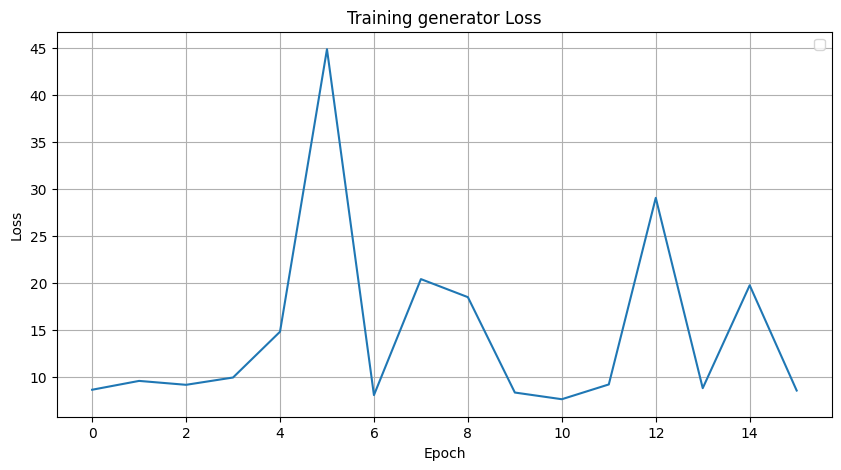

Epoch: 15 -- Generator Loss: 14.673356056213379, Discriminator Loss: 1.4479787349700928, Classifier Loss: 0.38165074586868286

Took 15.71182131767273 seconds. 


New best classifier loss, resetting patience.
Epoch:  16


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627]


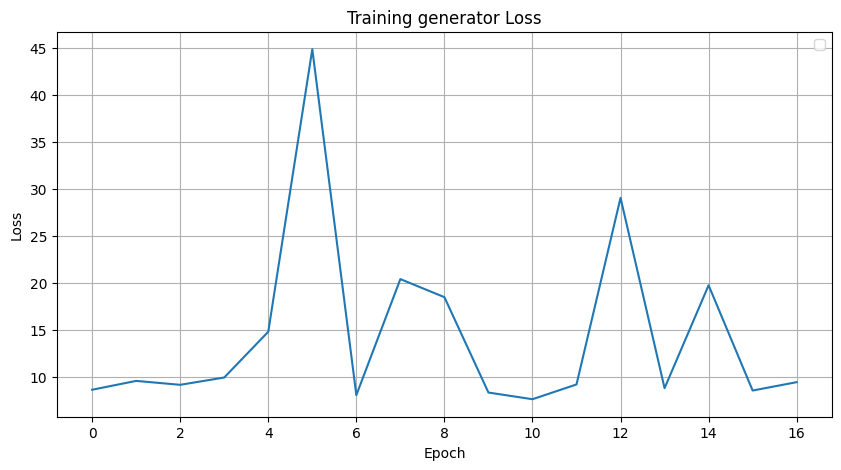

Epoch: 16 -- Generator Loss: 14.363136291503906, Discriminator Loss: 1.4409832954406738, Classifier Loss: 0.3746136724948883

Took 15.743839979171753 seconds. 


New best classifier loss, resetting patience.
Epoch:  17


46it [00:15,  2.97it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755]


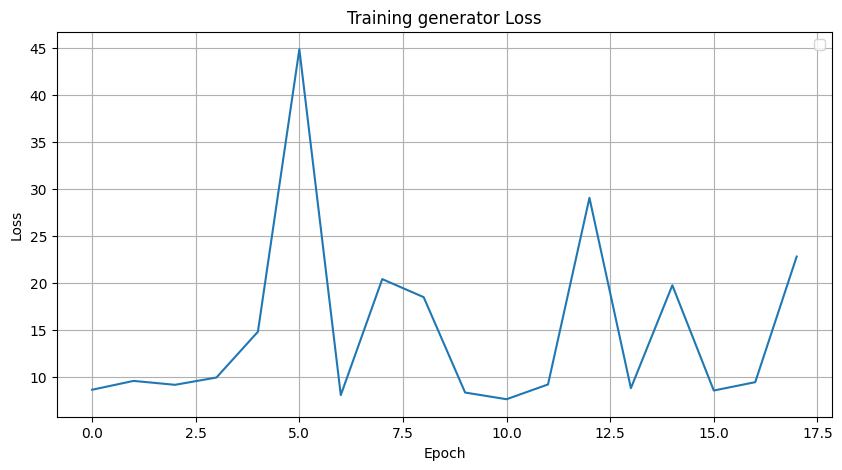

Epoch: 17 -- Generator Loss: 14.83144760131836, Discriminator Loss: 1.4340424537658691, Classifier Loss: 0.3621610701084137

Took 15.676210165023804 seconds. 


New best classifier loss, resetting patience.
Epoch:  18


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162]


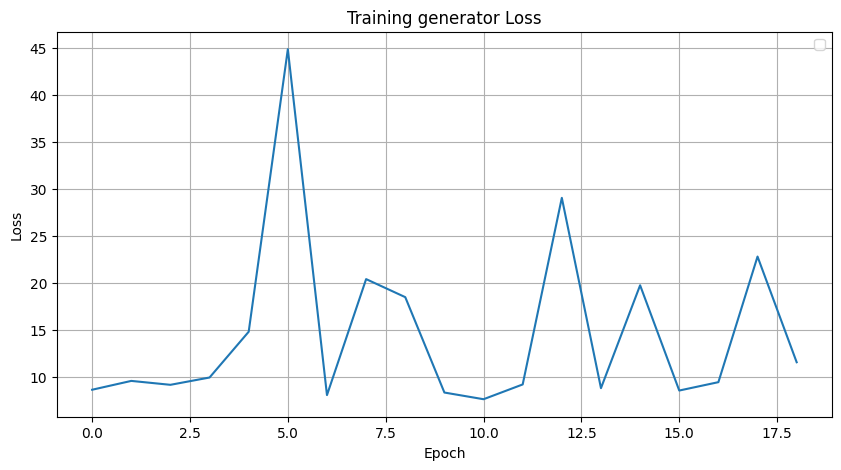

Epoch: 18 -- Generator Loss: 14.657327651977539, Discriminator Loss: 1.437822937965393, Classifier Loss: 0.35304078459739685

Took 15.711792230606079 seconds. 


New best classifier loss, resetting patience.
Epoch:  19


46it [00:15,  2.97it/s]


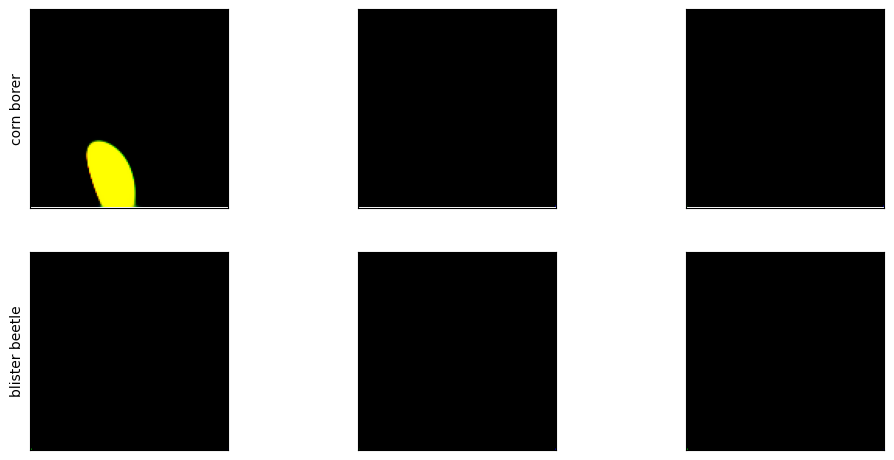

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384]


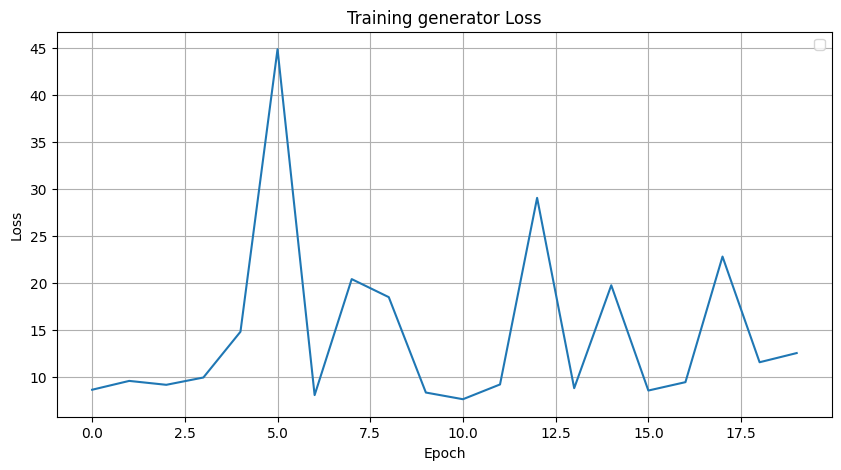

Epoch: 19 -- Generator Loss: 14.549580574035645, Discriminator Loss: 1.4476078748703003, Classifier Loss: 0.3499624729156494

Took 16.34998631477356 seconds. 


New best classifier loss, resetting patience.
Epoch:  20


46it [00:15,  2.98it/s]


[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287]


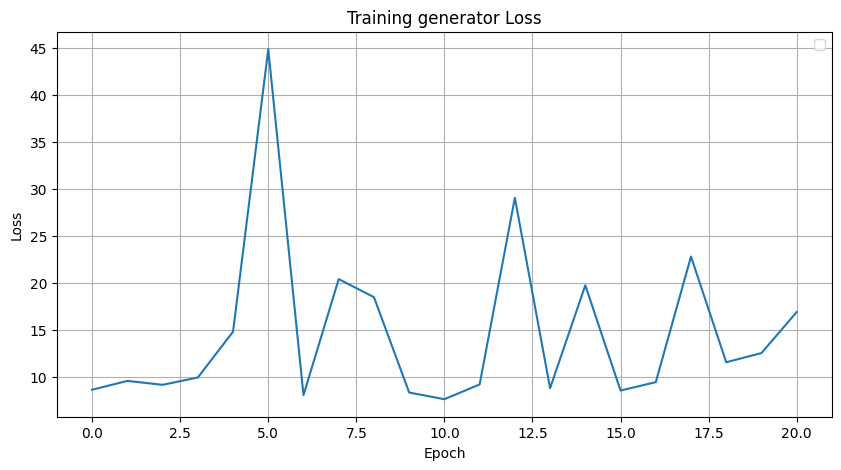

Epoch: 20 -- Generator Loss: 14.660233497619629, Discriminator Loss: 1.4375383853912354, Classifier Loss: 0.3414858877658844

Took 15.672300338745117 seconds. 


New best classifier loss, resetting patience.
Epoch:  21


46it [00:15,  2.97it/s]


[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867]


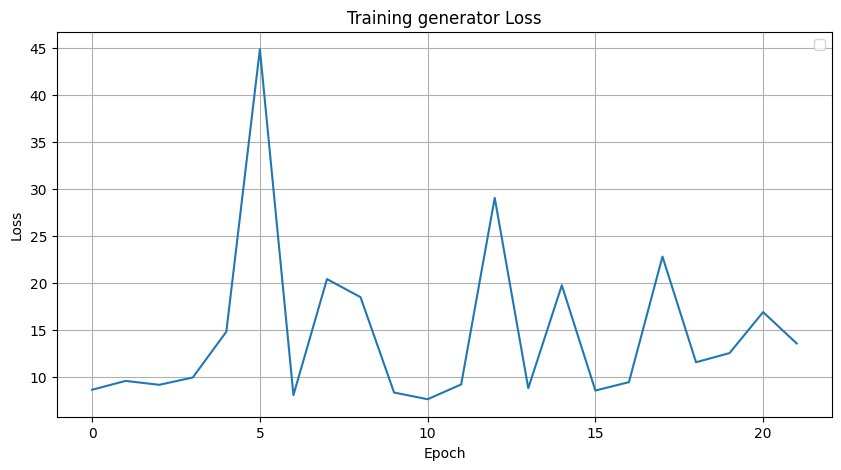

Epoch: 21 -- Generator Loss: 14.60876178741455, Discriminator Loss: 1.4335956573486328, Classifier Loss: 0.3314197361469269

Took 15.727158069610596 seconds. 


New best classifier loss, resetting patience.
Epoch:  22


46it [00:15,  2.95it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821]


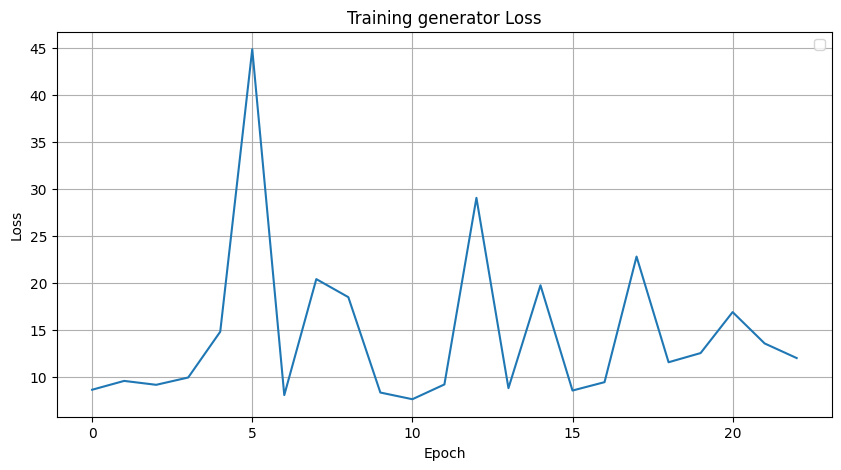

Epoch: 22 -- Generator Loss: 14.494025230407715, Discriminator Loss: 1.4353901147842407, Classifier Loss: 0.32419291138648987

Took 15.75750732421875 seconds. 


New best classifier loss, resetting patience.
Epoch:  23


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768]


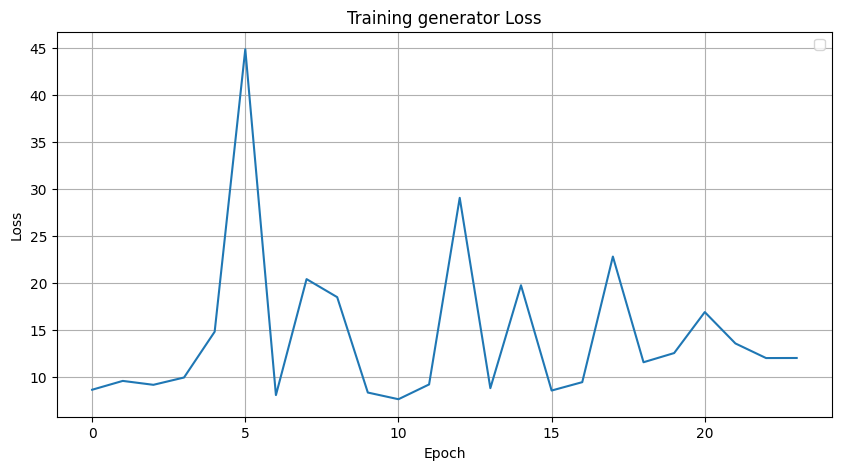

Epoch: 23 -- Generator Loss: 14.389142036437988, Discriminator Loss: 1.4313849210739136, Classifier Loss: 0.3378181755542755

Took 15.735625505447388 seconds. 


No improvement. Patience: 1/50
Epoch:  24


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256]


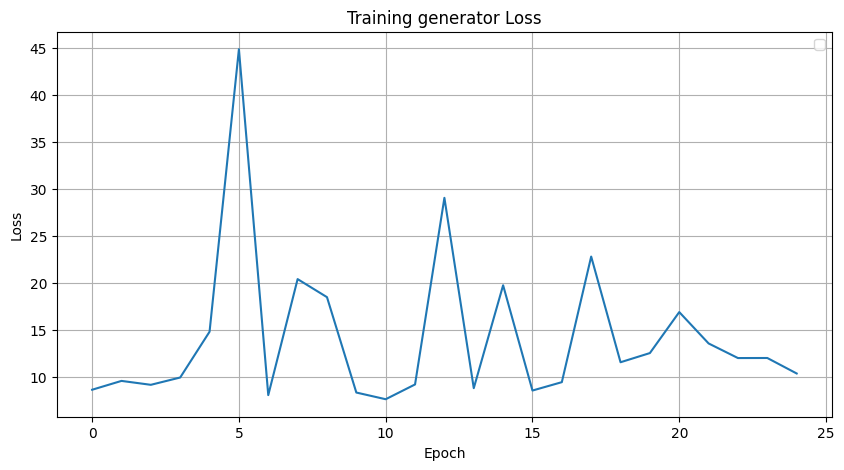

Epoch: 24 -- Generator Loss: 14.226587295532227, Discriminator Loss: 1.4278721809387207, Classifier Loss: 0.33074337244033813

Took 15.7308189868927 seconds. 


No improvement. Patience: 2/50
Epoch:  25


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362]


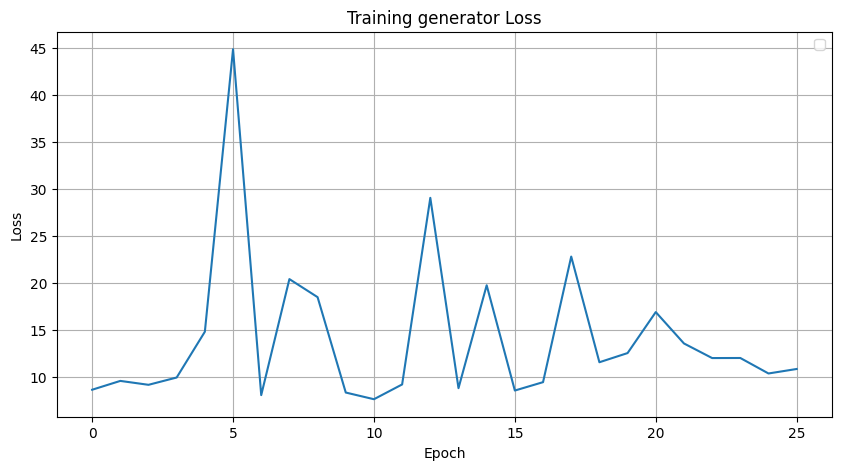

Epoch: 25 -- Generator Loss: 14.094962120056152, Discriminator Loss: 1.425960659980774, Classifier Loss: 0.323598712682724

Took 15.720906734466553 seconds. 


New best classifier loss, resetting patience.
Epoch:  26


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355]


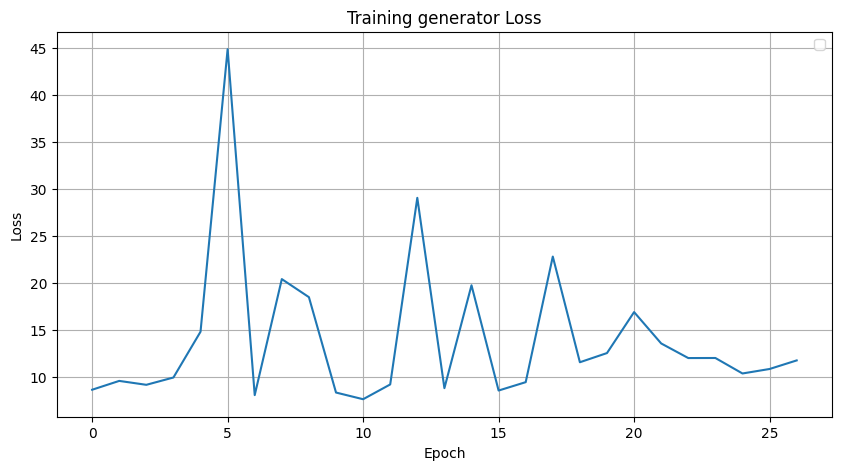

Epoch: 26 -- Generator Loss: 14.006939888000488, Discriminator Loss: 1.424710988998413, Classifier Loss: 0.32569560408592224

Took 15.728171110153198 seconds. 


No improvement. Patience: 1/50
Epoch:  27


46it [00:15,  2.95it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927]


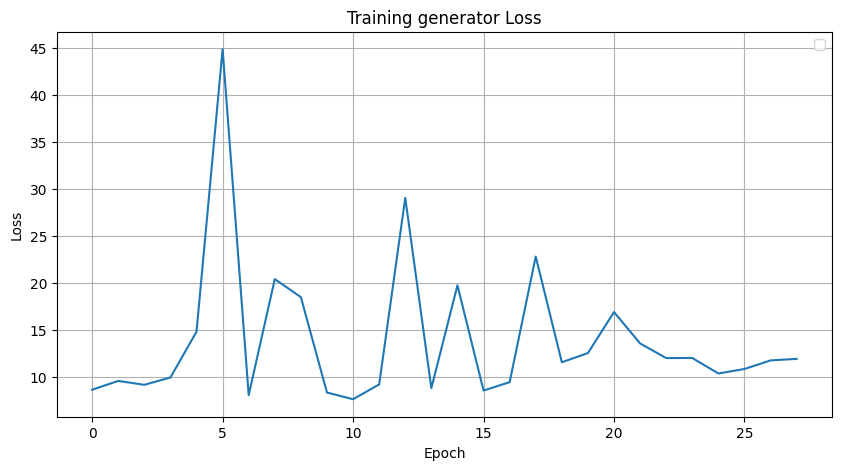

Epoch: 27 -- Generator Loss: 13.931118965148926, Discriminator Loss: 1.428004503250122, Classifier Loss: 0.3184841573238373

Took 15.744613647460938 seconds. 


New best classifier loss, resetting patience.
Epoch:  28


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837]


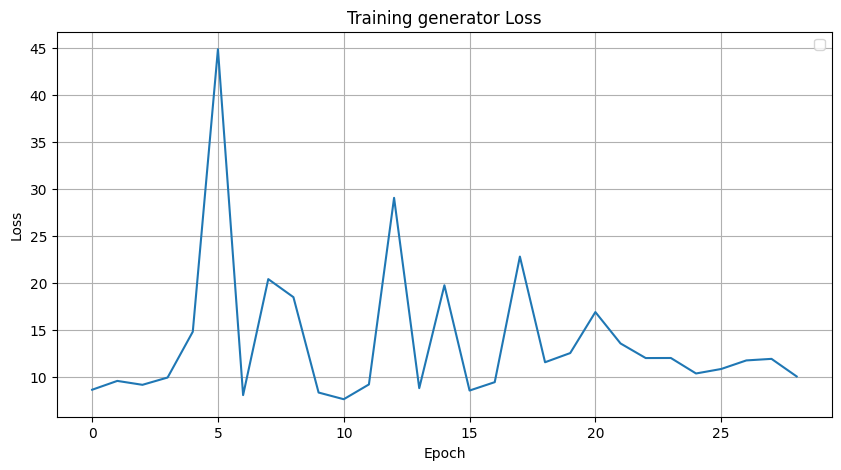

Epoch: 28 -- Generator Loss: 13.795867919921875, Discriminator Loss: 1.4280040264129639, Classifier Loss: 0.3132667541503906

Took 15.712812423706055 seconds. 


New best classifier loss, resetting patience.
Epoch:  29


46it [00:15,  2.96it/s]


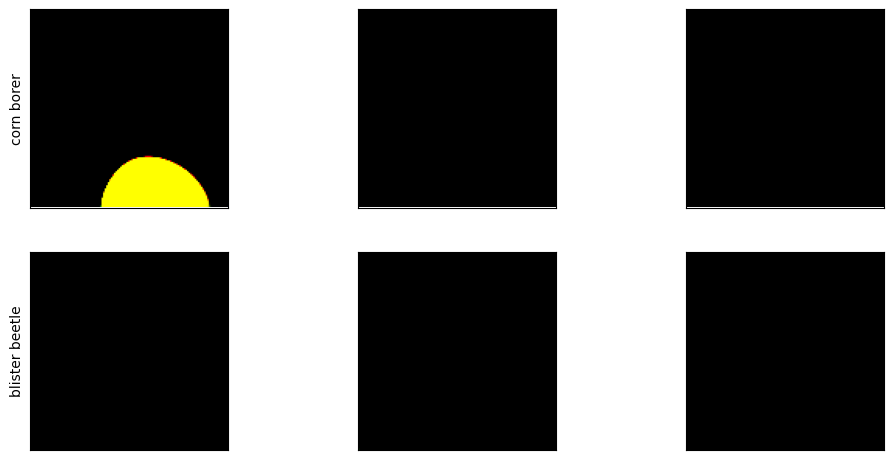

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325]


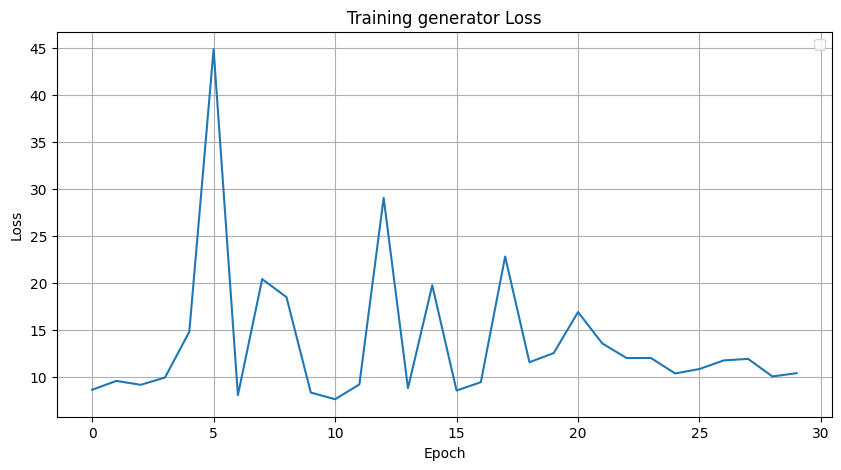

Epoch: 29 -- Generator Loss: 13.6812162399292, Discriminator Loss: 1.4490094184875488, Classifier Loss: 0.30677273869514465

Took 16.380544185638428 seconds. 


New best classifier loss, resetting patience.
Epoch:  30


46it [00:15,  2.98it/s]


[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256]


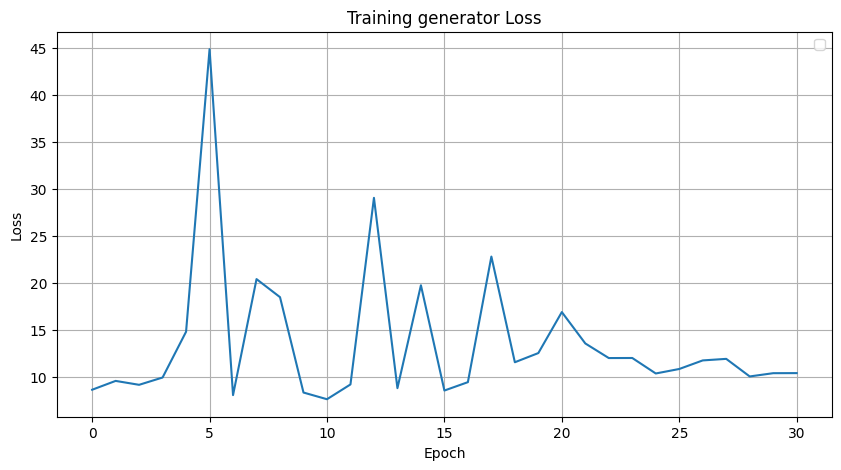

Epoch: 30 -- Generator Loss: 13.574217796325684, Discriminator Loss: 1.4498807191848755, Classifier Loss: 0.30518683791160583

Took 15.659968376159668 seconds. 


New best classifier loss, resetting patience.
Epoch:  31


46it [00:15,  2.97it/s]


[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251]


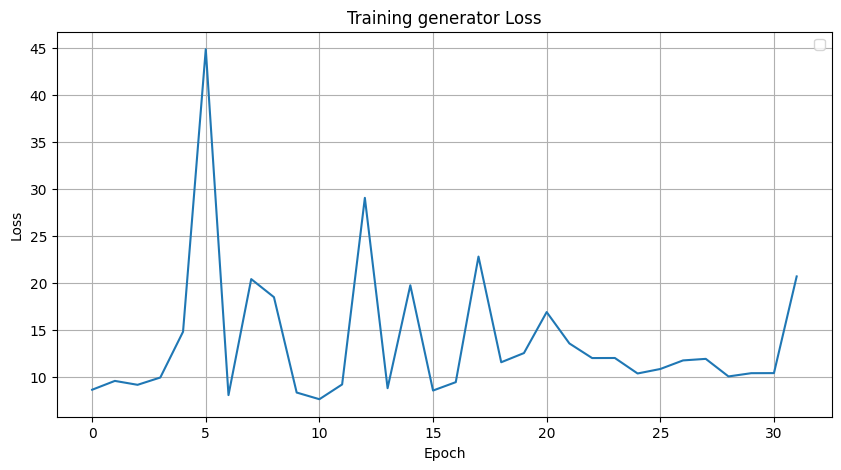

Epoch: 31 -- Generator Loss: 13.796123504638672, Discriminator Loss: 1.4670774936676025, Classifier Loss: 0.30549827218055725

Took 15.725014686584473 seconds. 


No improvement. Patience: 1/50
Epoch:  32


46it [00:15,  2.95it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271]


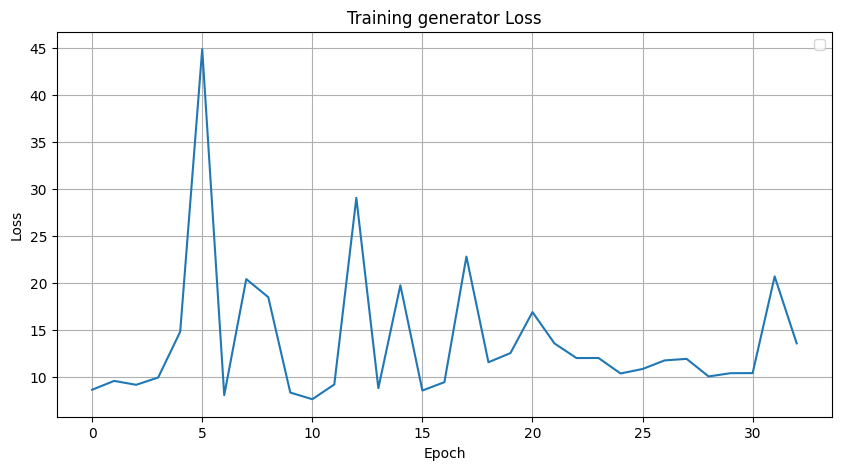

Epoch: 32 -- Generator Loss: 13.788310050964355, Discriminator Loss: 1.4627790451049805, Classifier Loss: 0.3001387417316437

Took 15.74593472480774 seconds. 


New best classifier loss, resetting patience.
Epoch:  33


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953]


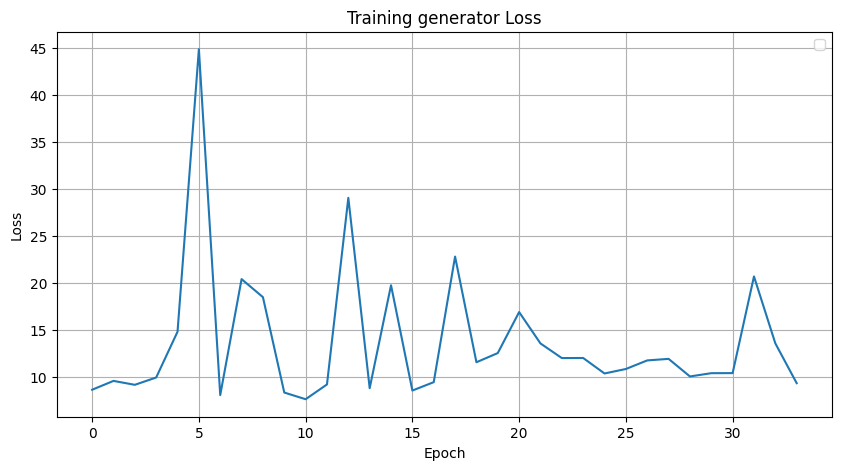

Epoch: 33 -- Generator Loss: 13.656034469604492, Discriminator Loss: 1.4569833278656006, Classifier Loss: 0.29662758111953735

Took 15.737387418746948 seconds. 


New best classifier loss, resetting patience.
Epoch:  34


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088]


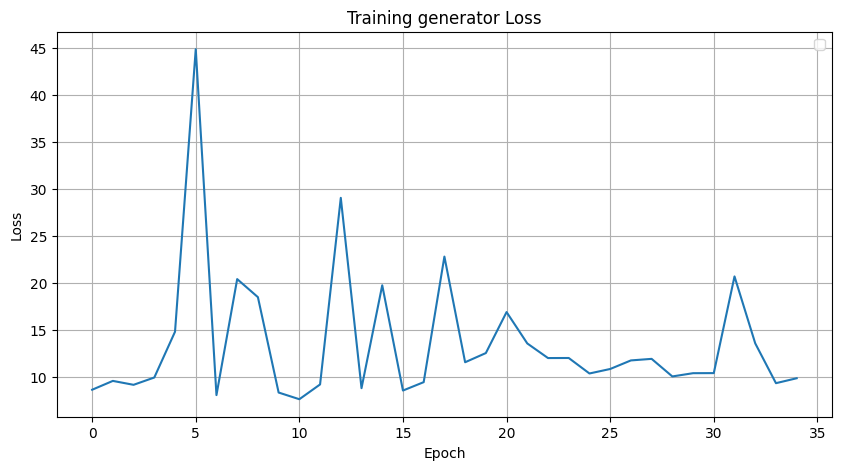

Epoch: 34 -- Generator Loss: 13.546350479125977, Discriminator Loss: 1.4485048055648804, Classifier Loss: 0.29570677876472473

Took 15.705601930618286 seconds. 


New best classifier loss, resetting patience.
Epoch:  35


46it [00:15,  2.96it/s]


[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327]


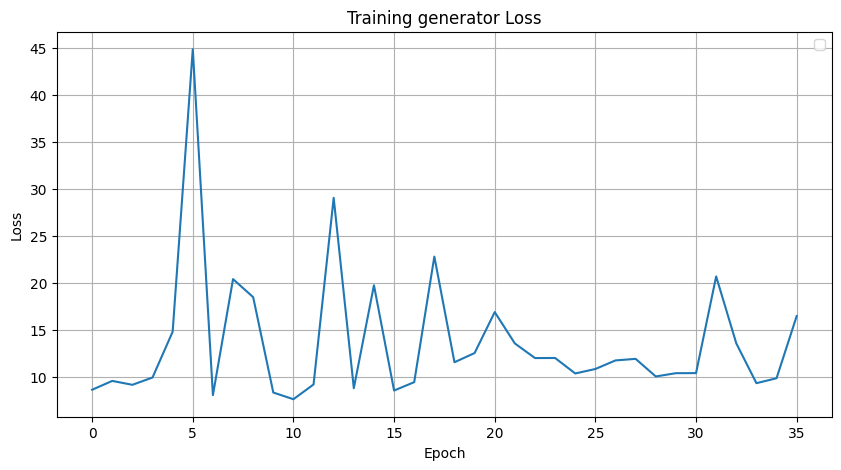

Epoch: 35 -- Generator Loss: 13.626738548278809, Discriminator Loss: 1.446176290512085, Classifier Loss: 0.2911478877067566

Took 16.97485637664795 seconds. 


New best classifier loss, resetting patience.
Epoch:  36


46it [00:15,  2.98it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695]


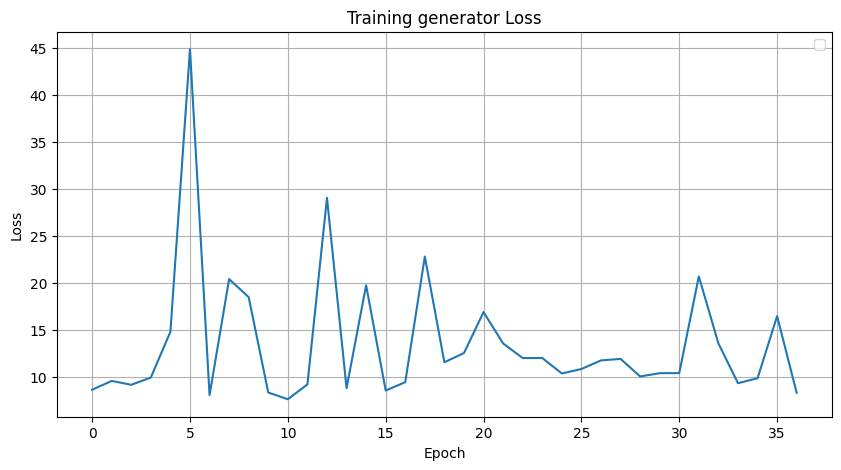

Epoch: 36 -- Generator Loss: 13.48187255859375, Discriminator Loss: 1.4391064643859863, Classifier Loss: 0.28642308712005615

Took 15.626546144485474 seconds. 


New best classifier loss, resetting patience.
Epoch:  37


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497]


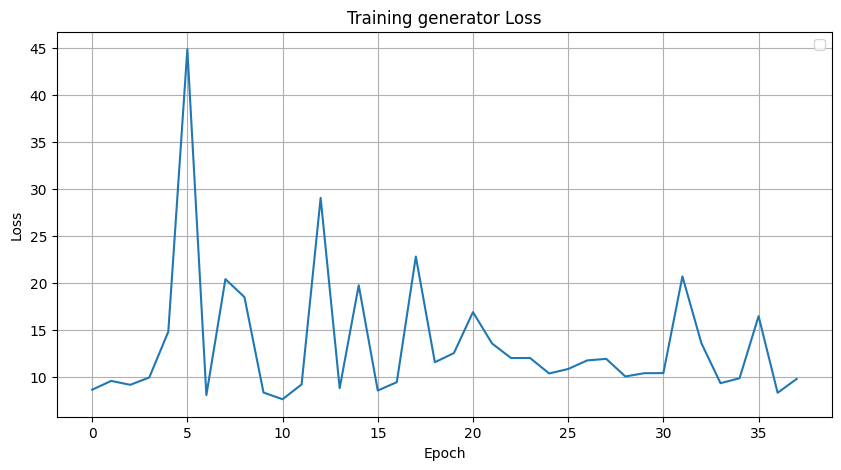

Epoch: 37 -- Generator Loss: 13.383572578430176, Discriminator Loss: 1.444696068763733, Classifier Loss: 0.2821141481399536

Took 15.713410377502441 seconds. 


New best classifier loss, resetting patience.
Epoch:  38


46it [00:15,  2.96it/s]


[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975]


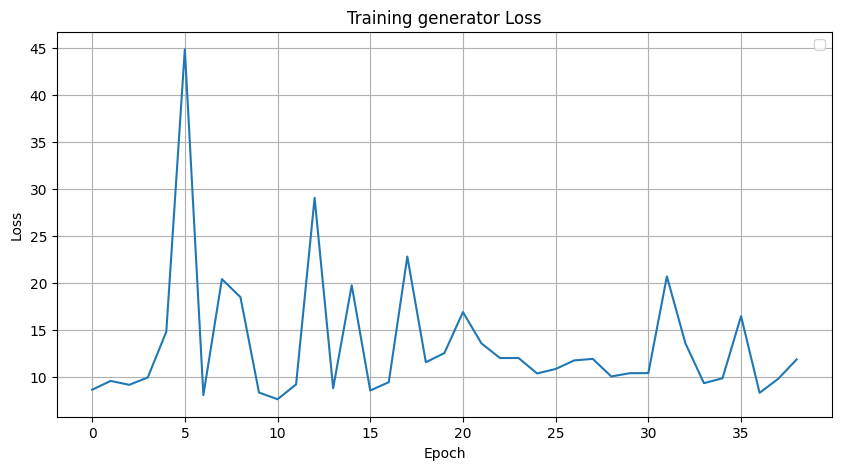

Epoch: 38 -- Generator Loss: 13.343637466430664, Discriminator Loss: 1.4462106227874756, Classifier Loss: 0.2783608138561249

Took 15.76605772972107 seconds. 


New best classifier loss, resetting patience.
Epoch:  39


46it [00:15,  2.96it/s]


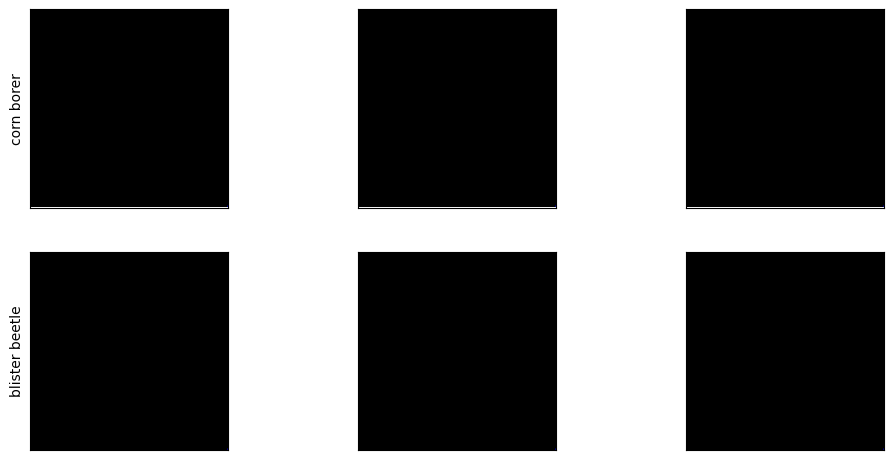

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313]


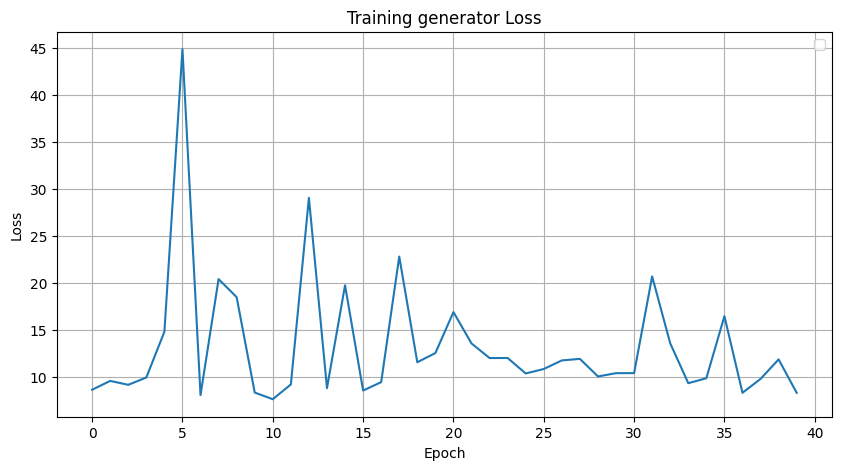

Epoch: 39 -- Generator Loss: 13.216656684875488, Discriminator Loss: 1.4458547830581665, Classifier Loss: 0.27526646852493286

Took 16.37697982788086 seconds. 


New best classifier loss, resetting patience.
Epoch:  40


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159]


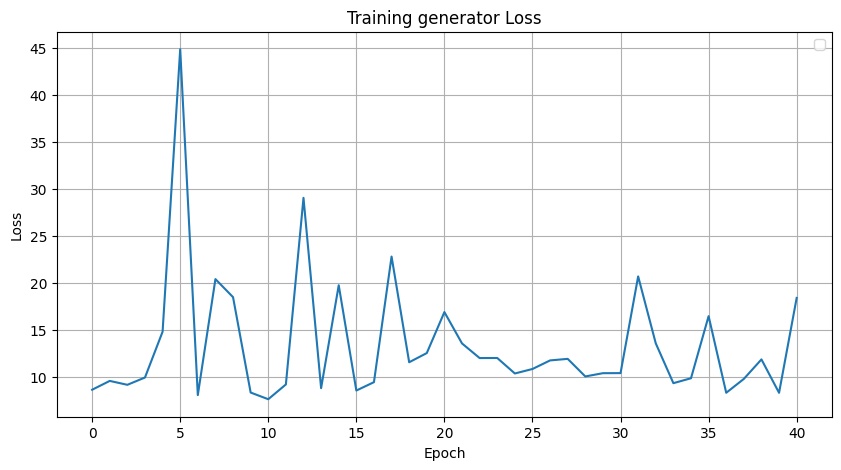

Epoch: 40 -- Generator Loss: 13.342717170715332, Discriminator Loss: 1.441580057144165, Classifier Loss: 0.28159576654434204

Took 15.706685543060303 seconds. 


No improvement. Patience: 1/50
Epoch:  41


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308]


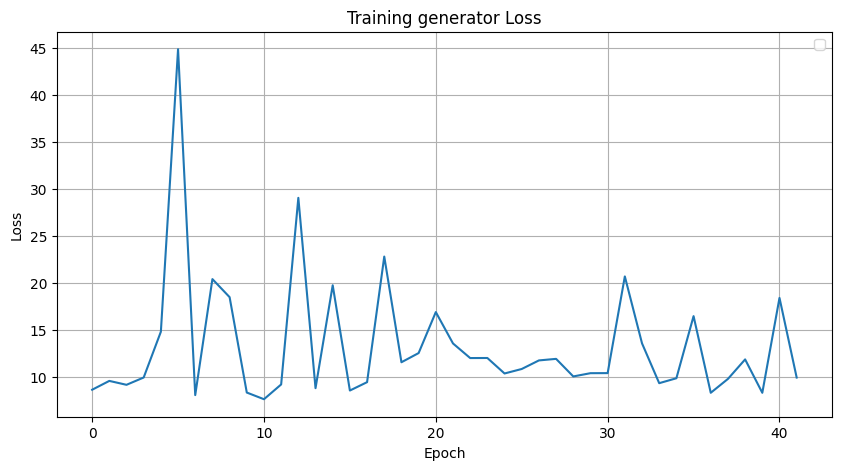

Epoch: 41 -- Generator Loss: 13.260564804077148, Discriminator Loss: 1.4714014530181885, Classifier Loss: 0.2789720892906189

Took 15.697540283203125 seconds. 


No improvement. Patience: 2/50
Epoch:  42


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308, 9.271856]


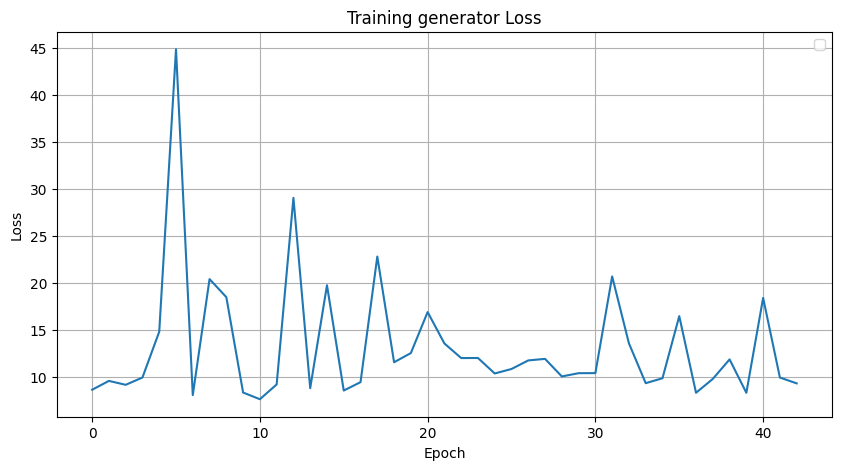

Epoch: 42 -- Generator Loss: 13.167803764343262, Discriminator Loss: 1.4710639715194702, Classifier Loss: 0.277452677488327

Took 15.705779075622559 seconds. 


No improvement. Patience: 3/50
Epoch:  43


46it [00:15,  2.95it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308, 9.271856, 10.586173]


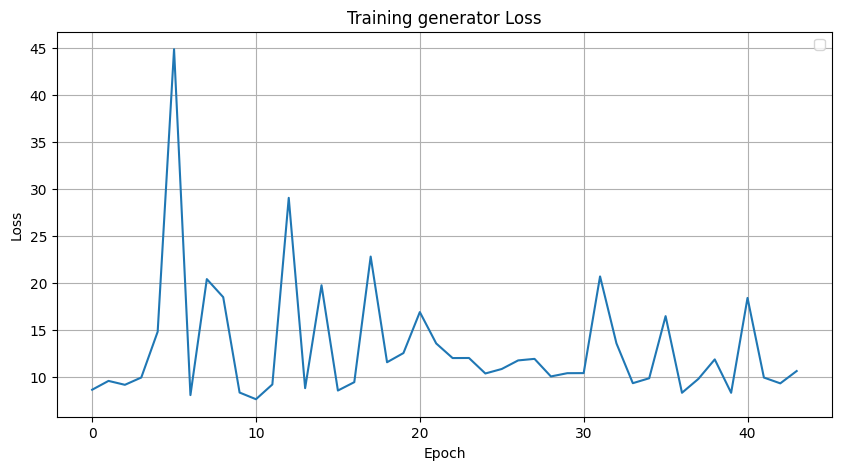

Epoch: 43 -- Generator Loss: 13.109130859375, Discriminator Loss: 1.4638820886611938, Classifier Loss: 0.2740650177001953

Took 15.776451587677002 seconds. 


New best classifier loss, resetting patience.
Epoch:  44


46it [00:15,  2.94it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308, 9.271856, 10.586173, 11.207977]


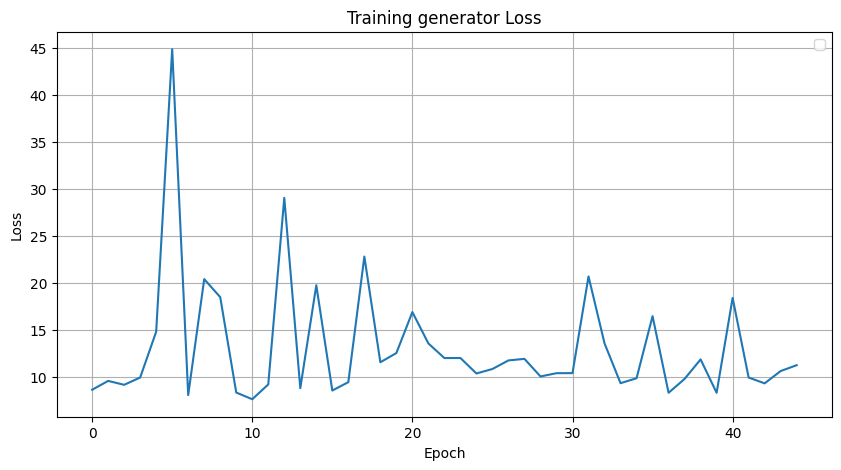

Epoch: 44 -- Generator Loss: 13.06688404083252, Discriminator Loss: 1.4656424522399902, Classifier Loss: 0.27104413509368896

Took 15.812840700149536 seconds. 


New best classifier loss, resetting patience.
Epoch:  45


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308, 9.271856, 10.586173, 11.207977, 13.358198]


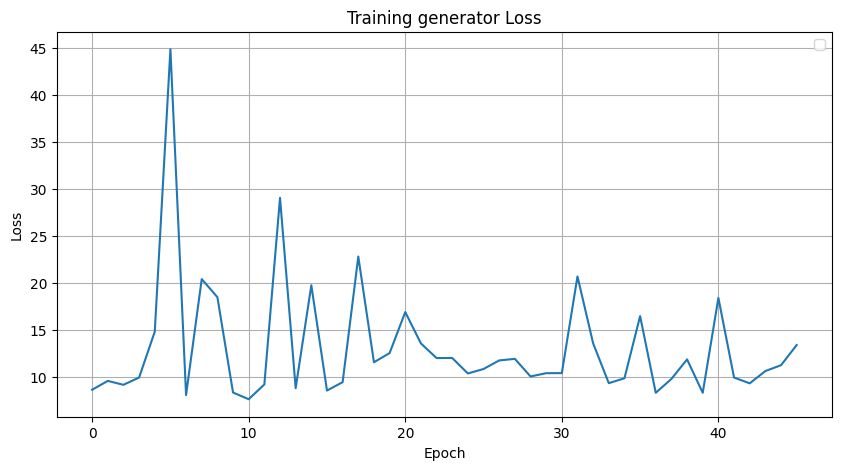

Epoch: 45 -- Generator Loss: 13.073217391967773, Discriminator Loss: 1.4617122411727905, Classifier Loss: 0.2682492733001709

Took 15.72385835647583 seconds. 


New best classifier loss, resetting patience.
Epoch:  46


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308, 9.271856, 10.586173, 11.207977, 13.358198, 12.765062]


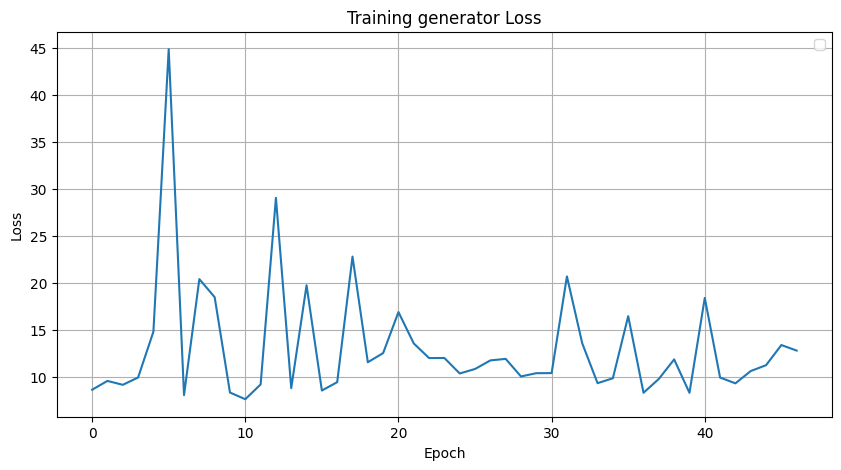

Epoch: 46 -- Generator Loss: 13.06666088104248, Discriminator Loss: 1.459218978881836, Classifier Loss: 0.2653915584087372

Took 15.73119068145752 seconds. 


New best classifier loss, resetting patience.
Epoch:  47


46it [00:15,  2.96it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308, 9.271856, 10.586173, 11.207977, 13.358198, 12.765062, 11.50181]


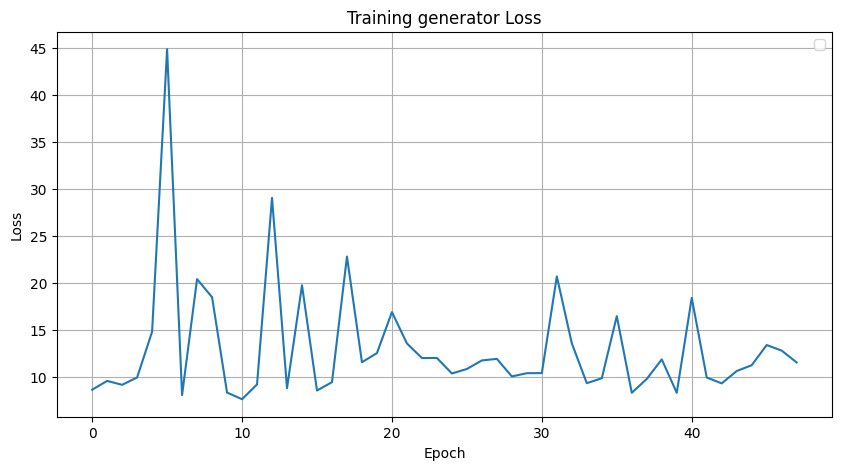

Epoch: 47 -- Generator Loss: 13.0340576171875, Discriminator Loss: 1.4560856819152832, Classifier Loss: 0.26236823201179504

Took 15.713488340377808 seconds. 


New best classifier loss, resetting patience.
Epoch:  48


46it [00:15,  2.94it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308, 9.271856, 10.586173, 11.207977, 13.358198, 12.765062, 11.50181, 8.929511]


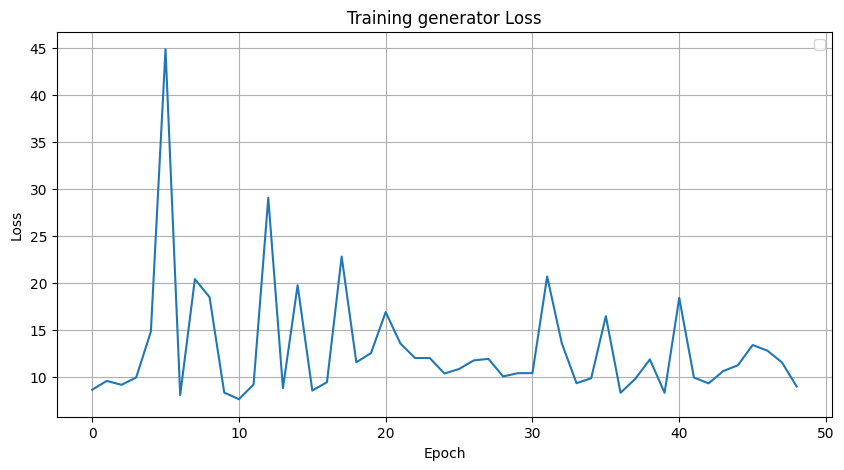

Epoch: 48 -- Generator Loss: 12.950291633605957, Discriminator Loss: 1.4494354724884033, Classifier Loss: 0.25955668091773987

Took 15.785867929458618 seconds. 


New best classifier loss, resetting patience.
Epoch:  49


46it [00:15,  2.96it/s]


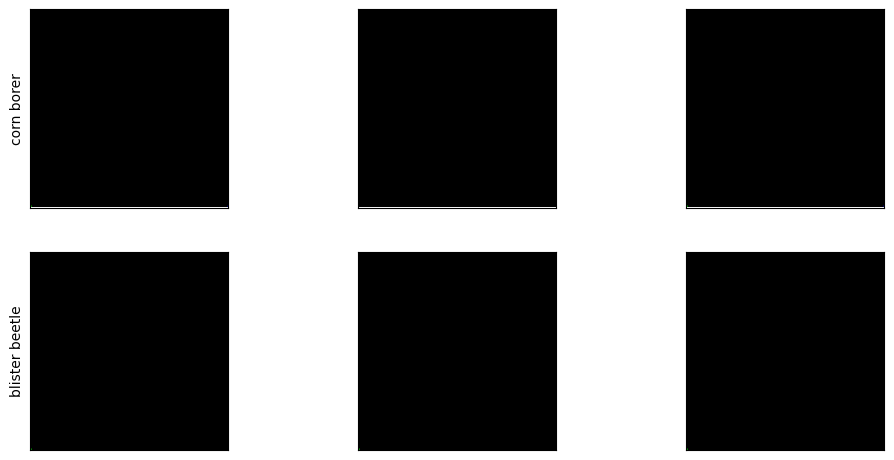

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308, 9.271856, 10.586173, 11.207977, 13.358198, 12.765062, 11.50181, 8.929511, 12.354519]


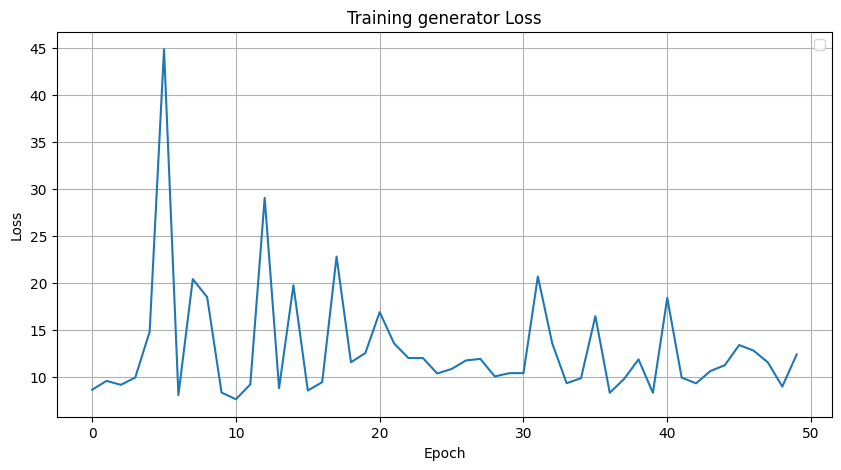

Epoch: 49 -- Generator Loss: 12.938375473022461, Discriminator Loss: 1.4466373920440674, Classifier Loss: 0.2568209767341614

Took 16.446492671966553 seconds. 


New best classifier loss, resetting patience.
Epoch:  50


46it [00:15,  2.98it/s]

[8.591385, 9.533569, 9.116479, 9.895554, 14.777089, 44.904846, 8.019145, 20.389118, 18.464539, 8.2925415, 7.58009, 9.155973, 29.055462, 8.759091, 19.732203, 8.5066185, 9.399627, 22.792755, 11.523162, 12.502384, 16.873287, 13.527867, 11.969821, 11.9768, 10.325256, 10.804362, 11.718355, 11.883927, 10.008837, 10.356325, 10.364256, 20.675251, 13.538271, 9.290953, 9.817088, 16.440327, 8.266695, 9.746497, 11.8260975, 8.264313, 18.385159, 9.892308, 9.271856, 10.586173, 11.207977, 13.358198, 12.765062, 11.50181, 8.929511, 12.354519, 11.494986]


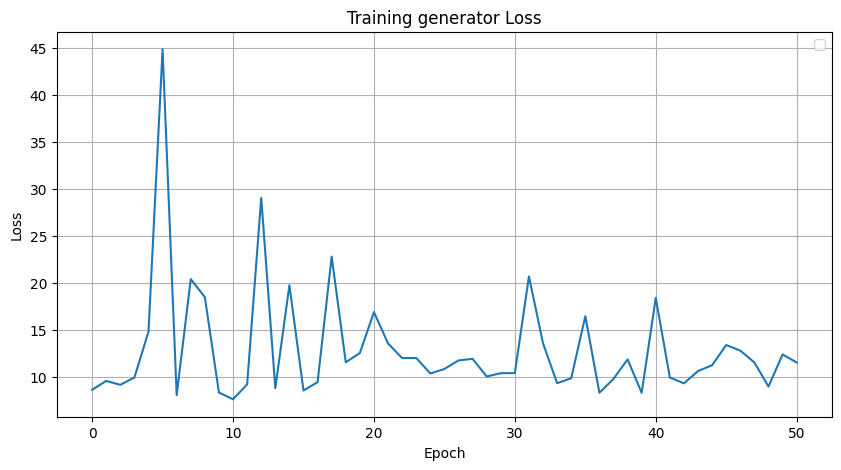

Epoch: 50 -- Generator Loss: 12.910073280334473, Discriminator Loss: 1.4423905611038208, Classifier Loss: 0.25407299399375916

Took 15.624684810638428 seconds. 


New best classifier loss, resetting patience.
Epoch:  51


36it [00:12,  2.97it/s]

In [ ]:
dic = f"GACN_result/{str(datetime.datetime.today())}"
os.mkdir(dic)
     
basic_info = {"train_size":train_size, "batch_size": batch_size, "image_size":img_size, "epoch": epoch_count, 
              "noise_dim":noise_dim, "n_class":n_class, "learning_rate_g": l_rate_g, "learning_rate_d":l_rate_d, 
              "learning_rate_c":l_rate_c, "beta_1":b1, "beta_2":b2,  "fake_coefficient":r, "weight_decay": weight_decay}

keys = basic_info.keys()
rows = basic_info.values()
with open(f"{dic}/basic_info.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(keys)
    writer.writerows([rows])

max_key_len = max(len(k) for k in basic_info.keys())
for k, v in basic_info.items():
    print(f"{k:<{max_key_len}} : {v}")
print("---------------------------------")

train(dataset, epochs=epoch_count)
g_model.save(f"{dic}/generator.keras")
d_model.save(f"{dic}/discriminator.keras") 
c_model.save(f"{dic}/classifier.keras")